<center> <h1> **Fraud Detection**</h1> <br>
<h2>
This is a simulated credit card transaction dataset created by an A.I. that has legitimate and fraudulent transactions during the span of *1st Jan 2019 - 31st Dec 2020.* <br> It contains the records of credit card purchases of 1000 customers doing transactions spanning from 800 different merchants. 	</h2></center>
<p>
1. trans_date_trans_time<br>
2. cc_num<br>
3. merchant name<br>
4. category (of purchase type)<br>
5. amt (amount of purchase)<br>
6. first last (name)<br>
7. gender<br>
8. zip (zipcode of customer) ((probably don't need this if we convert the lat&long to zipcodes))<br>
9.	lat of customer home address(latitude)	<br>
10. long of cust home address(longitude)	<br>
11. city_pop of cust<br>
12.	job	<br>
13. dob(date of birth)<br>	
14. trans_num(transaction number)<br>	
15. unix_time	<br>
16. merch_lat	(merchant latitude)<br>
17. merch_long (merchant longitude)	<br>
18. is_fraud (binary classifier)<br>
</p>


<center><h2> In this project will employ the Semi-Supervised Learning using the following techniques:</center></h2>

1. Stacking, boosting and bagging for creation of Meta-Classifiers
2. DNN and Keras metrics for imbalanced data
3. Random forest 
4. Anomaly detection w/ LOF  &  Isolation Forest models
5. SVC
6. KNN clusters
7. Ridge Regression
8. Extra Trees
9. TSNE w/ KNN

#Import & Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas
import pandas as pd
import seaborn as sns
from decimal import Decimal
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.stats import skew, boxcox
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import average_precision_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVR
from sklearn.svm import SVC
import itertools
import time
from warnings import filterwarnings
from sklearn import ensemble
from sqlalchemy import create_engine
from scipy.stats import zscore
pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline


###Exploratory dataset

In [ ]:
#This is strictly to pull up unique() and nunique() after modifying our dataset later on
fraud_df = pd.read_csv('https://storage.googleapis.com/datasets_for_analysis/fraudTest%5B1%5D.csv', index_col = False, error_bad_lines=False)

#This code will create dummy columns for all the category options of purchases and rewrite the DF to be onehot encoded!
#fraud_df = pd.get_dummies(fraud_df, prefix='cat', prefix_sep='.', columns=['category'], drop_first=True)

#This will delete the first column which is just a row counter
fraud_df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

###Dataset for modeling

In [ ]:
#import csv files from the Google Storage Database
fraud_df_test = pd.read_csv('https://storage.googleapis.com/datasets_for_analysis/fraudTest%5B1%5D.csv', index_col = False, error_bad_lines=False)
#all code to pull up csv
fraud_df_train= pd.read_csv('https://storage.googleapis.com/datasets_for_analysis/fraudTrain.csv', index_col = False, error_bad_lines=False)

#Concat the dataframs together
fraud = pd.concat([fraud_df_train, fraud_df_test])
fraud.reset_index(drop=True, inplace=True)
fraud.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
fraud.head(1)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0


#Functions



In [ ]:
#This is a great test to check for outliers
def grubbs_test(x):
    n = len(x)
    mean_x = np.mean(x)
    sd_x = np.std(x)
    numerator = max(abs(x-mean_x))
    g_calculated = numerator/sd_x
    print("Grubbs Calculated Value:",g_calculated)
    t_value = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)
    g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))
    print("Grubbs Critical Value:",g_critical)
    if g_critical > g_calculated:
        print("From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers\n")
    else:
        print("From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers\n")

#Simply boxplot
def Box_plots(df):
    plt.figure(figsize=(10, 4))
    plt.title("Box Plot")
    sns.boxplot(df)
    plt.show()

#Simple histogram plot
def hist_plots(df):
    plt.figure(figsize=(10, 4))
    plt.hist(df)
    plt.title("Histogram Plot")
    plt.show()

#Simple scatter plot
def scatter_plots(df1,df2):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.scatter(df1,df2)
    ax.set_xlabel('Age')
    ax.set_ylabel('Fare')
    plt.title("Scatter Plot")
    plt.show()

#To get a tukey to help with outliers
def get_tukey(df,tukey_col):
    q75, q25 = np.percentile(df[tukey_col], [75 ,25])
    iqr = q75 - q25
    tukey_dict = {}
    for threshold in np.arange(1,5.5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
#        print("The score threshold is: {}".format(threshold))
        num_outliers = len((np.where((df[tukey_col] > max_val) | (df[tukey_col] < min_val))[0]))
#        print("Number of outliers is: {}".format(num_outliers))
        tukey_dict.update({threshold: [min_val, max_val, num_outliers]})
    return tukey_dict

#For a zscore 
def get_zscore(df,z_col):
    z_scores = zscore(df[z_col])
    z_dict = {}
    for threshold in range(1,5):
        print("The score threshold is: {}".format(threshold))
        print("The indices of the outliers:")
        outlier_indices = np.where(z_scores > threshold)
        print(outlier_indices)
        num_outliers = len((np.where(z_scores > threshold)[0]))
        print("Number of outliers is: {}".format(num_outliers))
        z_dict.update({threshold: outlier_indices})
    return z_dict

In [ ]:
#Notice in the 'merchant' column for some reason the word 'fraud_' is printed infront of each retailer, let's remove that
fraud.replace("fraud_", "", regex=True, inplace=True) 
#Rename columns
fraud_df.rename(columns={'trans_date_trans_time': 'trans_date_time'}, inplace=True)

In [ ]:
#Group columns for easier analysis
fraud['customer_name'] = fraud['first'] + [' '] + fraud['last']

In [ ]:
#split the date time to two separate columns
fraud_df['trans_date_time'] = pd.to_datetime(fraud_df['trans_date_time']) 
fraud_df['date'] = fraud_df['trans_date_time'].dt.strftime('%d/%m/%Y')
#fraud_df_train['time'] = fraud_df_train['trans_date_time'].dt.strftime('%H:%M')

#Drop the trans_date_time column now that it's split
fraud_df.drop(columns='trans_date_time', inplace=True)
#Drop unnecessary columns
fraud.drop(columns=['city', 'state', 'street', 'first', 'last'], inplace=True)

#Exploratory Data Analysis

##Check for duplicates

In [ ]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF_train = fraud[fraud.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF_train)

Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [trans_date_trans_time, cc_num, merchant, category, amt, gender, zip, lat, long, city_pop, job, dob, trans_num, unix_time, merch_lat, merch_long, is_fraud, customer_name]
Index: []


In [ ]:
fraud.set_index(['customer_name'], inplace=True)

Check for nulls

In [ ]:
#This will check to see the percentage of data that is null
fraud.isnull().sum()*100/fraud.isnull().count()

trans_date_trans_time   0.00
cc_num                  0.00
merchant                0.00
category                0.00
amt                     0.00
gender                  0.00
zip                     0.00
lat                     0.00
long                    0.00
city_pop                0.00
job                     0.00
dob                     0.00
trans_num               0.00
unix_time               0.00
merch_lat               0.00
merch_long              0.00
is_fraud                0.00
dtype: float64

In [ ]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, Jennifer Banks to Samuel Frey
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   gender                 object 
 6   zip                    int64  
 7   lat                    float64
 8   long                   float64
 9   city_pop               int64  
 10  job                    object 
 11  dob                    object 
 12  trans_num              object 
 13  unix_time              int64  
 14  merch_lat              float64
 15  merch_long             float64
 16  is_fraud               int64  
dtypes: float64(5), int64(5), object(7)
memory usage: 254.4+ MB


In [ ]:
#Lets transform this column so that we can do some simple math
fraud_df['is_fraud'].astype(str).astype(int)

#Determine how much of the data is fraud vs normal transactions
fraud_true = fraud_df[fraud_df['is_fraud'] == 1]
fraud_true =  fraud_true.shape[0]
normal = fraud_df[fraud_df['is_fraud'] == 0]
normal = normal.shape[0]
print('The amount of fraudulent transactions in the dataset are: {}'.format(fraud_true))
print('The amount of normal transactions in the dataset are: {}'.format(normal))
print('The percentage of fraud in our training data is: {:.4f} %' .format(fraud_true/normal))

The amount of fraudulent transactions in the dataset are: 2145
The amount of normal transactions in the dataset are: 553574
The percentage of fraud in our training data is: 0.0039 %


###*This data is highly unbalanced as only .4% of all transactions here are fraudulent, so it's literally going to be like finding a needle in a haystack. See figure below for a visual.

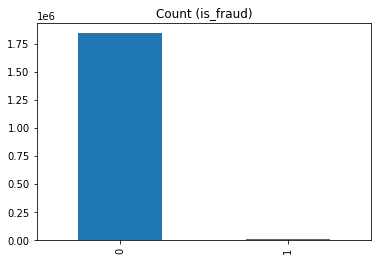

In [ ]:
fraud.is_fraud.value_counts().plot(kind='bar', title='Count (is_fraud)');

<h3>This shows the distribution of purchase amounts for fraudulent transactions**</h3>


In [ ]:
#Lets transform this back so that we can plot it
fraud_df['is_fraud'].astype(str).astype(object)
fraud_true = fraud_df[fraud_df['is_fraud'] == 1]
normal = fraud_df[fraud_df['is_fraud'] == 0]
fraud_true.amt.describe()

count   2145.00
mean     528.36
std      392.75
min        1.78
25%      214.51
50%      371.94
75%      907.77
max     1320.92
Name: amt, dtype: float64

<h3>We see here that the max amount of a fraudulent purchase is only $1376**</h3>


In [ ]:
normal.amt.describe()

count   553574.00
mean        67.61
std        152.47
min          1.00
25%          9.60
50%         47.15
75%         82.62
max      22768.11
Name: amt, dtype: float64

<h3>We see here that the max amount of a normal purchase is only $22768**</h3>


##Plot distribution of key columns




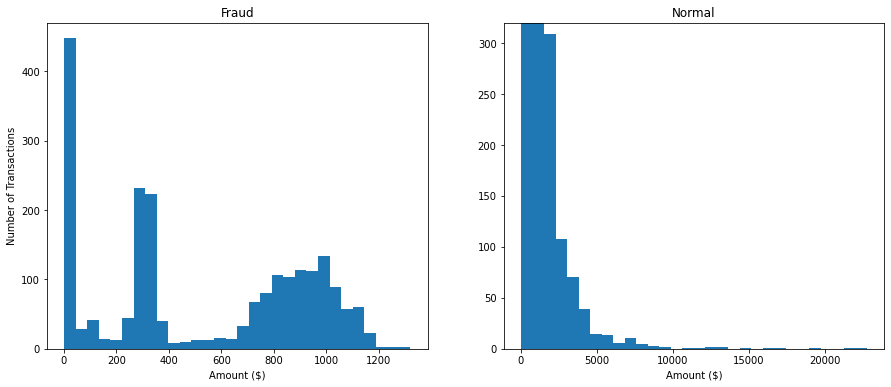

In [ ]:
#Switch the column datatype back to object in order to call the hist function
fraud_explore = fraud_df[fraud_df['is_fraud'] == 1]
normal_explore = fraud_df[fraud_df['is_fraud'] == 0]

# amount comparison - How different is the amount of money used in different transaction classes?
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
bins = 30

ax1.hist(fraud_explore['amt'], bins=bins)
ax2.hist(normal_explore['amt'], bins=bins)

ax1.set_title('Fraud')
ax2.set_title('Normal')

ax1.set_xlabel('Amount ($)')
ax2.set_xlabel('Amount ($)')
ax1.set_ylabel('Number of Transactions')

ax2.set_ylim(0, 320)
plt.show()

<h3>As we can see, the non-fradulent list of purchase amounts has many outliers</h3>




##Preprocessing unbalanced data

Categories of Purchase Distributions
---



The different categories that we can check for our model are:<br>
personal_care', 'health_fitness', 'misc_pos', 'travel',
       'kids_pets', 'shopping_pos', 'food_dining', 'home',
       'entertainment', 'shopping_net', 'misc_net', 'grocery_pos',
       'gas_transport', 'grocery_net'

In [ ]:
#Create a copy of the df in order to do onehot encoding and save the original dataframe
categories = fraud[['category', 'gender']].copy()

#Get dummies for categories and gender
fraud_cat = pd.get_dummies(categories[['category', 'gender']], drop_first=True)

In [ ]:
#Drop unnecessary column
#fraud.drop(fraud.category, axis=1, inplace=True)

#Combine the two arrays
fraud_cat.reset_index(drop=True, inplace=True)
fraud.reset_index(drop=True, inplace=True)
fraud = pd.concat([fraud, fraud_cat], axis=1, sort=False)
fraud.reset_index(drop=True, inplace=True)

In [ ]:
# Class count
count_class_0, count_class_1 = fraud.is_fraud.value_counts()

#Determine how much of the data is fraud vs normal transactions
fraud_true = fraud_df[fraud_df['is_fraud'] == 1]
normal_true = fraud_df[fraud_df['is_fraud'] == 0]

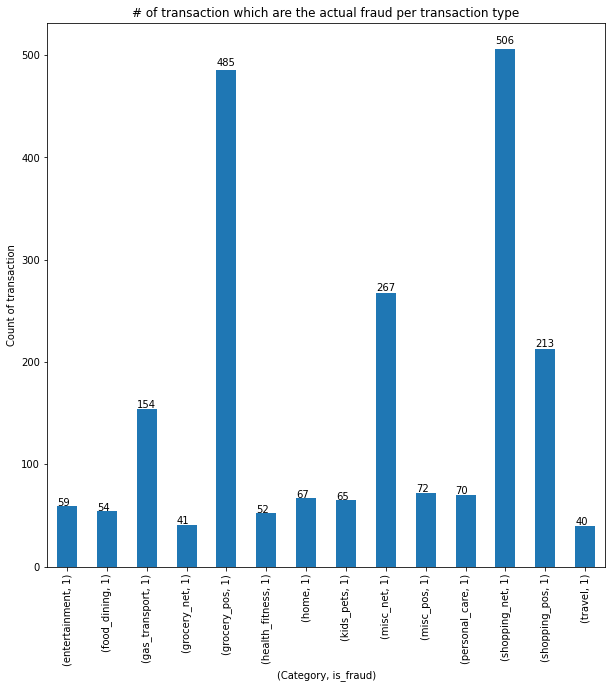

In [ ]:
#This will show us all of the fraudulent transactions in their respective categories

plt.figure(figsize=[10,10])
ax = fraud_true.groupby(['category', 'is_fraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Category, is_fraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

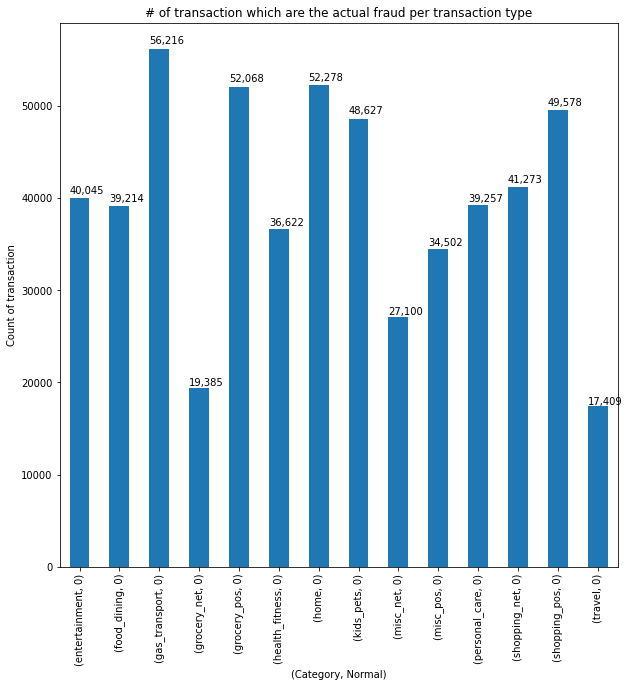

In [ ]:
#This will show us all of the normal transactions in their respective categories

plt.figure(figsize=[10,10])
ax = normal_true.groupby(['category', 'is_fraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Category, Normal)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

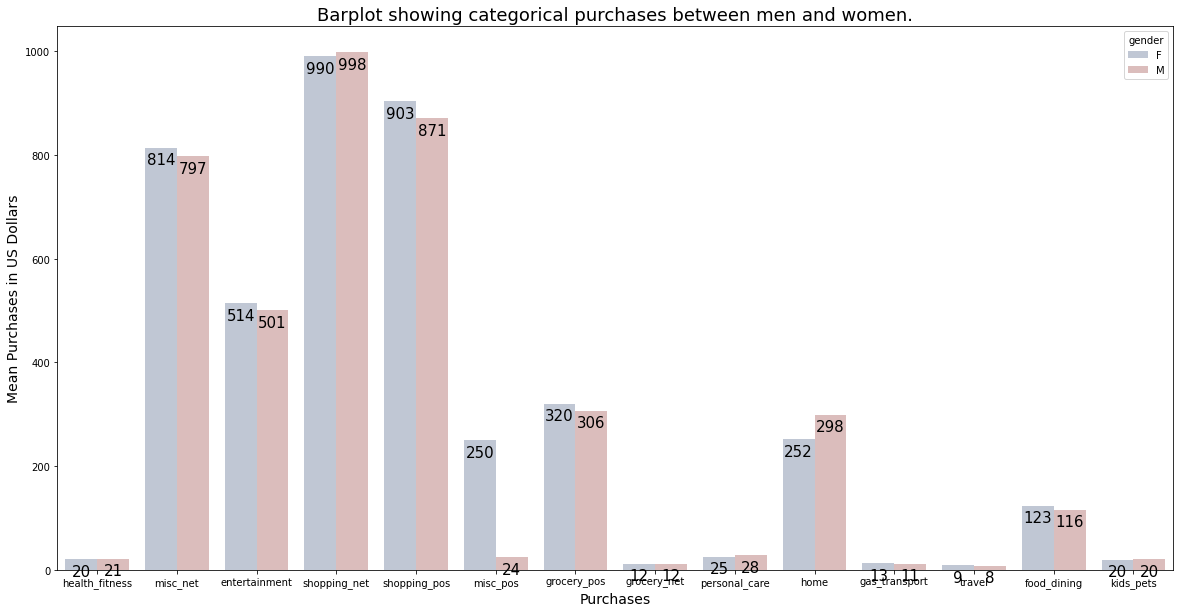

In [ ]:
plt.figure(figsize=(20, 10))
splot=sns.barplot(x="category", y="amt", hue="gender", palette="vlag", ci=None, data=fraud_true)
plt.ylabel("Mean Purchases in US Dollars", size=14)
plt.xlabel("Purchases", size=14)
plt.title("Barplot showing categorical purchases between men and women.", size=18)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.savefig('Categorical ',dpi=150)

##Find Correlation

['cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel', 'gender_M']
**Correlation Matrix (filtered for correlation above 0.5):**


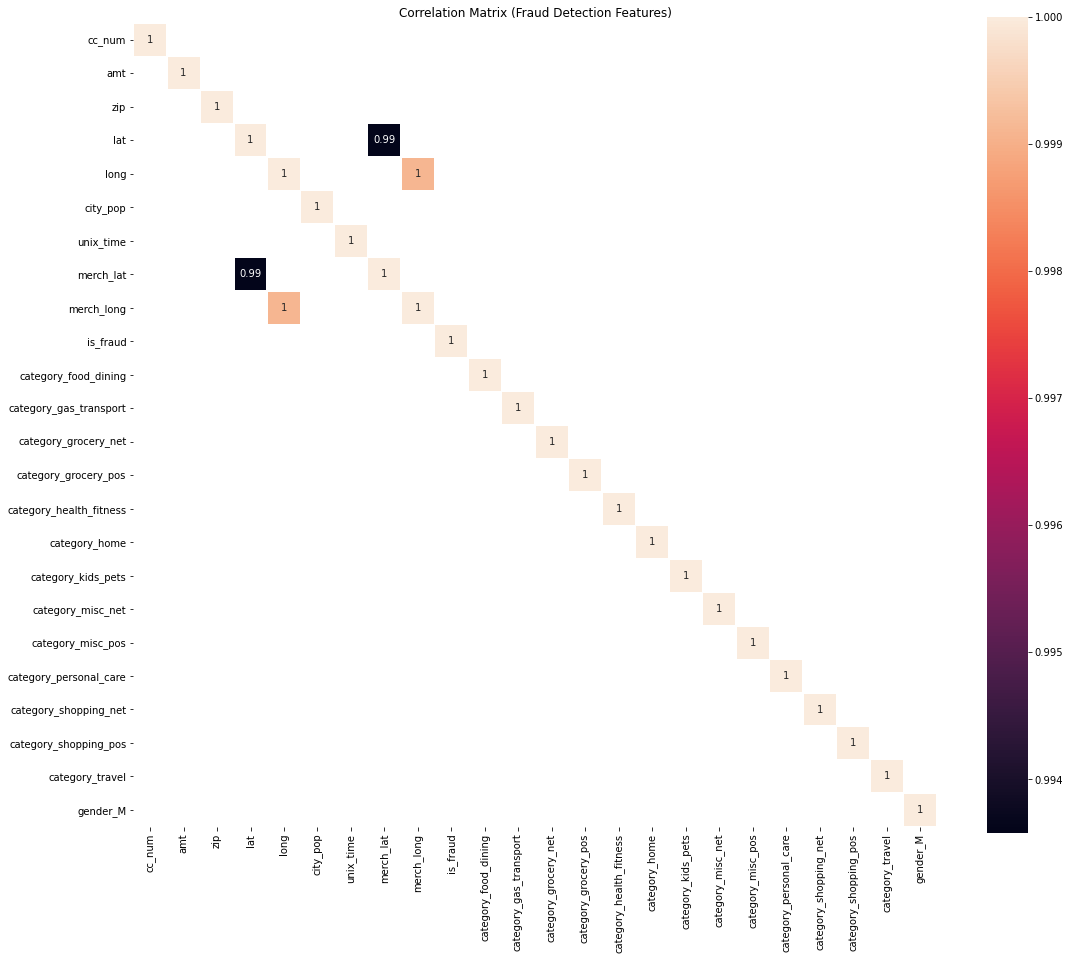

In [ ]:
# correlate life expectancy to all variables:
corr = fraud_df.corr()

def draw_heatmap(df,corr_thresh=.5):
    """ Draws heatmap out of a dataframe. 
        Set corr_thresh to -1000 for full heatmap,
        or keep default for strong correlation
    """
    
    # make the correlation matrix.
    corr_mat = df.corr()

    # move the column to head of list using index, pop and insert
    cols = corr_mat.columns.to_list()
    print (cols)

    # reorder
    corr_mat = corr_mat.loc[:, cols]
    corr_mat.sort_values(by=['is_fraud'],ascending=False)

    # figure aesthetics
    plt.figure(figsize=(18,15))
    plt.plot()
    
    # draw the heatmap using seaborn.
    sns.heatmap(corr_mat[(corr_mat > corr_thresh)], square=True, annot=True, linewidths=.5)
    plt.title("Correlation Matrix (Fraud Detection Features)")
    print("**Correlation Matrix (filtered for correlation above {}):**".format(corr_thresh))
    plt.show()

draw_heatmap(fraud)

Show outliers
---



The score threshold is: 1
The indices of the outliers:
(array([   100,    133,    167, ..., 553484, 553492, 553502]),)
Number of outliers is: 18103
The score threshold is: 2
The indices of the outliers:
(array([   133,    167,    405, ..., 553378, 553492, 553502]),)
Number of outliers is: 8237
The score threshold is: 3
The indices of the outliers:
(array([   133,    167,    428, ..., 553084, 553350, 553492]),)
Number of outliers is: 4406
The score threshold is: 4
The indices of the outliers:
(array([   167,    428,    720, ..., 553084, 553350, 553492]),)
Number of outliers is: 2520




/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 Show tukey 



{1.0: [-63.42000000000001, 155.64000000000001, 40381],
 1.5: [-99.93000000000002, 192.15000000000003, 26498],
 2.0: [-136.44000000000003, 228.66000000000003, 16488],
 2.5: [-172.95000000000002, 265.17, 12693],
 3.0: [-209.46000000000004, 301.68000000000006, 10678],
 3.5: [-245.97000000000006, 338.19000000000005, 9234],
 4.0: [-282.48, 374.70000000000005, 8182],
 4.5: [-318.99, 411.21000000000004, 7349],
 5.0: [-355.5, 447.72, 6467]}

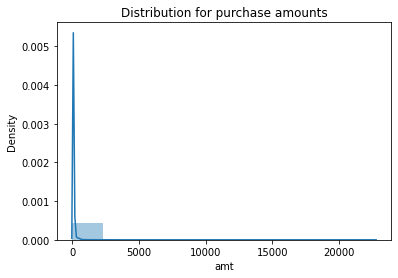

In [ ]:
get_zscore(normal, 'amt')
print('\n')
plt.title('Distribution for purchase amounts')
ax1 = sns.distplot(normal['amt'],bins=10)
print('\n Show tukey \n')
get_tukey(normal, 'amt')

<h2>This shows that the distribution is negatively skewed very strongly, let's take a closer look.</h2>

<h2>Shows fraudulent outliers in the 'amount' column.</h2>

count   2145.00
mean     528.36
std      392.75
min        1.78
25%      214.51
50%      371.94
75%      907.77
max     1320.92
Name: amt, dtype: float64


Grubbs Calculated Value: 2.0184676612318446
Grubbs Critical Value: 4.2222424903417055
From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers

None


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


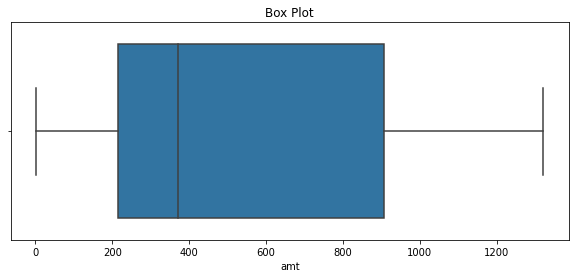

In [ ]:
#This checks if we have outliers in our fraud cases
print(fraud_true['amt'].describe())
print('\n')
print(grubbs_test(fraud_true['amt']))

#This prints the distribution of the 'AMT' column
Box_plots(fraud_true['amt'])

In [ ]:
#This shows the z score for the normal purchases
get_zscore(normal, 'amt')
print('\n This shows the non-fraudulent purchases.')

The score threshold is: 1
The indices of the outliers:
(array([   100,    133,    167, ..., 553484, 553492, 553502]),)
Number of outliers is: 18103
The score threshold is: 2
The indices of the outliers:
(array([   133,    167,    405, ..., 553378, 553492, 553502]),)
Number of outliers is: 8237
The score threshold is: 3
The indices of the outliers:
(array([   133,    167,    428, ..., 553084, 553350, 553492]),)
Number of outliers is: 4406
The score threshold is: 4
The indices of the outliers:
(array([   167,    428,    720, ..., 553084, 553350, 553492]),)
Number of outliers is: 2520

 This shows the non-fraudulent purchases.


<h2>Shows normal transaction outliers in the 'amount' column.</h2>

count   553574.00
mean        67.61
std        152.47
min          1.00
25%          9.60
50%         47.15
75%         82.62
max      22768.11
Name: amt, dtype: float64


Grubbs Calculated Value: 148.8832468768014
Grubbs Critical Value: 5.345123639735664
From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers

None


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


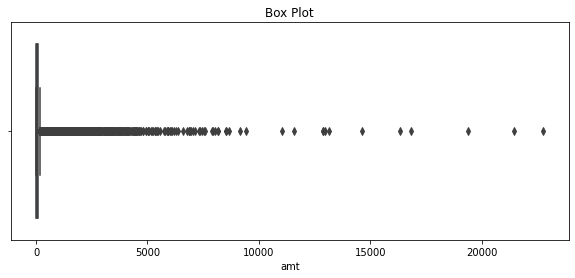

In [ ]:
#This checks if we have outliers in our normal purchases
print(normal_true['amt'].describe())
print('\n')
print(grubbs_test(normal_true['amt']))

#This prints the distribution of the 'AMT' column
Box_plots(normal_true['amt'])

In [ ]:
#This shows the z score for the fraudulent purchases
get_zscore(fraud_true, 'amt')
print('\n This shows the fraudulent purchases.')

The score threshold is: 1
The indices of the outliers:
(array([   3,    6,    7,    8,    9,   17,   30,   34,   37,   39,   48,
         50,   51,   52,   62,   64,   68,   69,   70,   72,   74,   80,
         92,   94,   99,  110,  116,  117,  120,  125,  126,  133,  144,
        147,  150,  195,  198,  204,  208,  212,  213,  221,  227,  234,
        237,  239,  240,  242,  251,  253,  254,  255,  256,  261,  262,
        264,  269,  276,  277,  279,  280,  283,  288,  289,  291,  299,
        302,  303,  306,  315,  323,  324,  326,  336,  341,  343,  345,
        346,  349,  355,  358,  378,  380,  387,  390,  393,  397,  403,
        404,  406,  417,  418,  419,  427,  429,  435,  439,  440,  441,
        450,  452,  453,  455,  456,  458,  459,  460,  461,  468,  477,
        485,  493,  494,  495,  527,  530,  534,  541,  542,  543,  546,
        573,  574,  580,  588,  592,  597,  605,  621,  623,  636,  640,
        641,  642,  646,  647,  648,  651,  663,  664,  667,  670,  

#Scale the features

In [ ]:
from sklearn import preprocessing
from scipy.stats import skew, boxcox

#Train/Test Split

#Undersampling data to train the model

###This will create a 10 to 1 ratio of Normal to Fraud transactions for modeling

In [ ]:
# Class count
count_class_0, count_class_1 = fraud.is_fraud.value_counts()

# Divide by class
df_class_0 = fraud[fraud['is_fraud'] == 0]
df_class_1 = fraud[fraud['is_fraud'] == 1]

df_class_0_under = df_class_0.sample(count_class_1*5)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling :')
print(df_under.is_fraud.value_counts())

Random under-sampling :
0    48255
1     9651
Name: is_fraud, dtype: int64


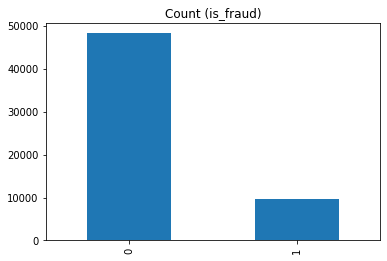

In [ ]:
df_under.is_fraud.value_counts().plot(kind='bar', title='Count (is_fraud)');

In [ ]:
#This will delete the first column which is just a row counter
#df_under.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
#df_under.columns

In [ ]:
len_after = len(df_under)
len_before = len(fraud)
len_difference = len(fraud) - len(df_under)
print('**We reduced our data size from {} transactions by {} transactions to {} transactions for our training data.**'.format(len_before, len_difference, len_after))

**We reduced our data size from 1852394 transactions by 1794488 transactions to 57906 transactions for our training data.**


###**We reduced our data size from 1852394 transactions by 1794488 transactions to 57906 transactions for our training data.**

### Feature Engineering

####*create customer age feature*

In [ ]:
df_under.head(1)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
650517,2019-10-04 12:21:12,5359543825610251,Kassulke PLC,shopping_net,6.00,M,59714,45.78,-111.14,18182,"Engineer, drilling",1975-06-29,859dbaa0260e1fbf3165654fb0f9437e,1349353272,46.21,-110.23,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
df_under['trans_date_trans_time'] = pd.to_datetime(df_under['trans_date_trans_time'])
df_under['unix_time'] = pd.to_datetime(df_under['unix_time'])
df_under['dob'] = pd.to_datetime(df_under['dob'])

In [ ]:
df_under['cust_age'] = df_under['trans_date_trans_time'].dt.year - df_under['dob'].dt.year


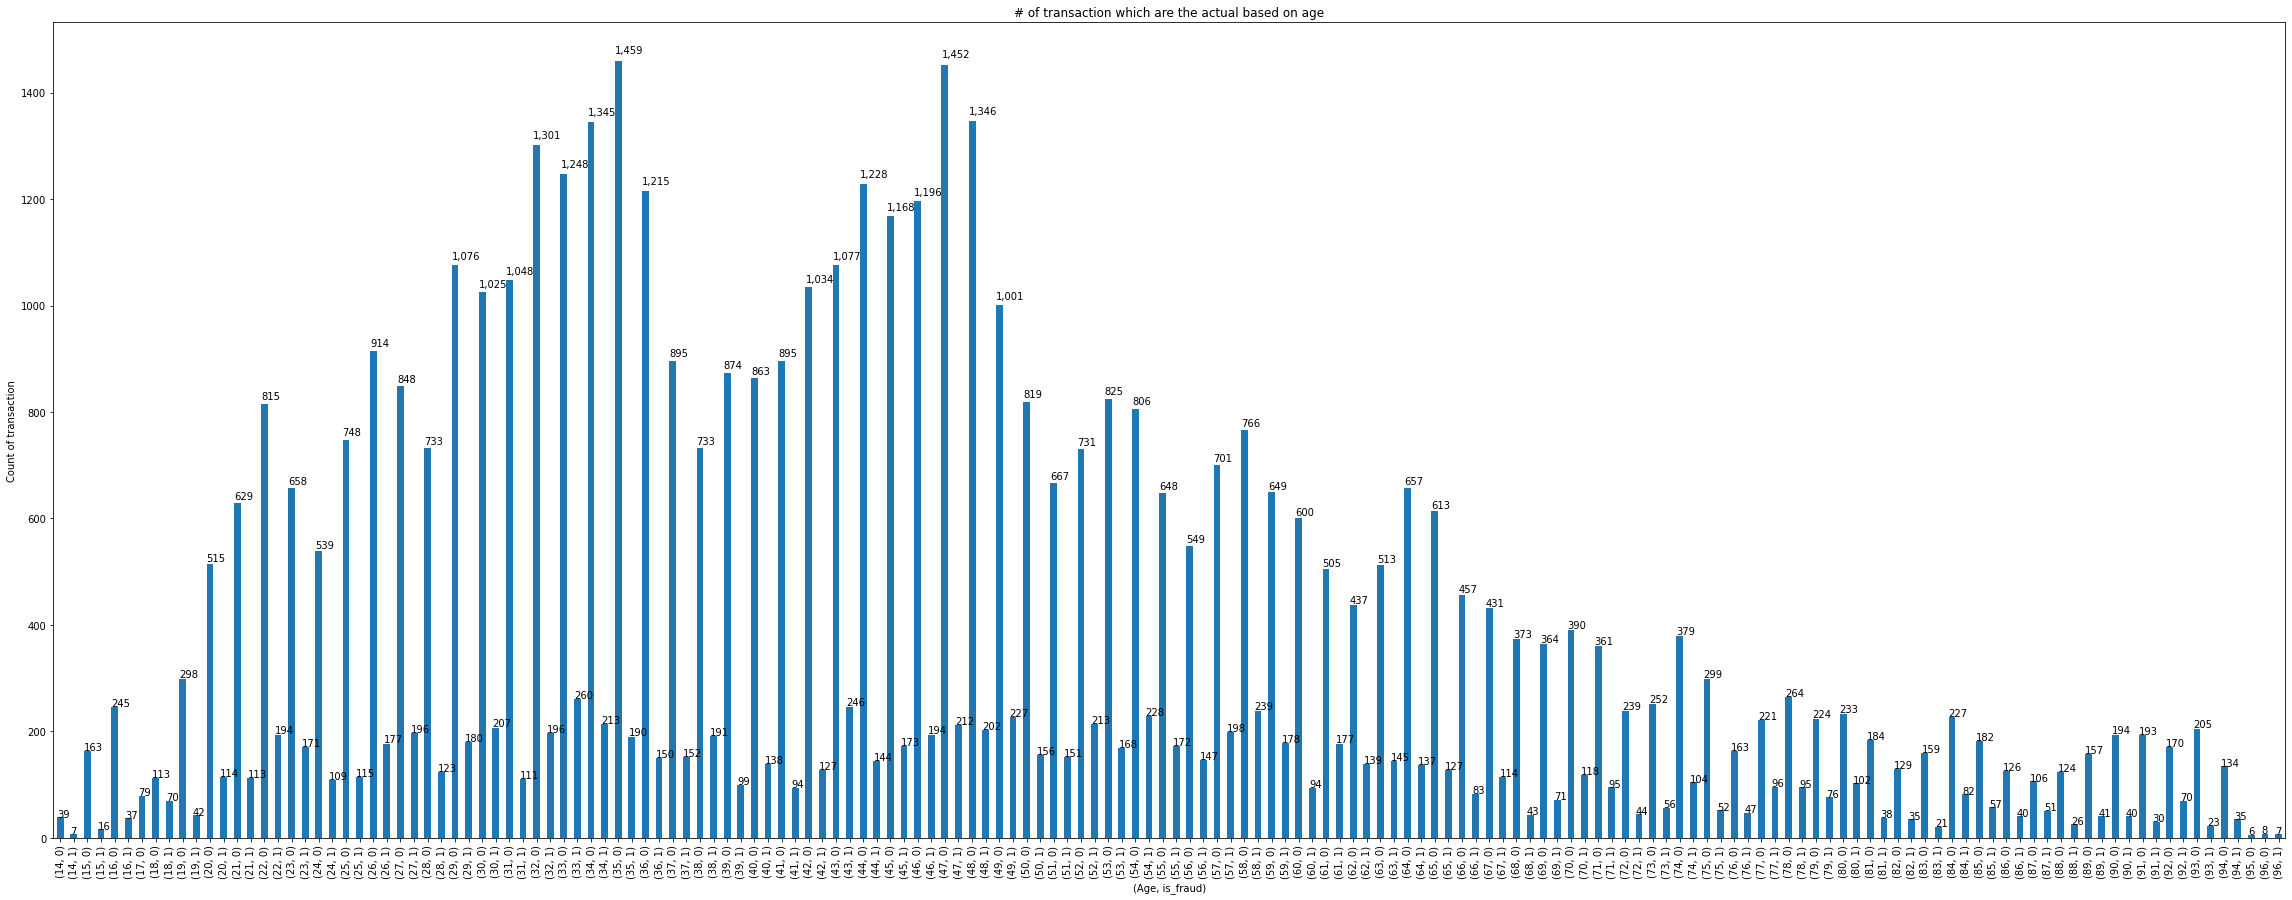

In [ ]:
#This will show us all of the fraudulent transactions and the number of times they have occured by age group.

plt.figure(figsize=[40,15])
ax = df_under.groupby(['cust_age', 'is_fraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual based on age")
ax.set_xlabel("(Age, is_fraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

<h2>We can see two large groups that have high amounts of fraudulent transactions on their account are ages (28-35) and (41-48).</h2>

In [ ]:
df_under.drop(['cc_num', 'merchant', 'zip',
              'dob', 'trans_num',], axis=1, inplace=True)
df_under.reset_index(drop=True, inplace=True)

In [ ]:
df_under.to_csv('unskewed_data.csv')

In [ ]:
df_under.columns

Index(['trans_date_trans_time', 'category', 'amt', 'gender', 'lat', 'long',
       'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M', 'cust_age'],
      dtype='object')

### Feature & Target Split


In [ ]:
feat_list = ['category', 'amt', 'gender', 'city_pop', 'cust_age', 'job']
feat_data = df_under[feat_list]
targ_list = ['is_fraud']
targ_data = df_under[targ_list]


### Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
#create the specs for the column transformer
from sklearn.preprocessing import MinMaxScaler
#categories="auto" and drop="first" tell the encoder to create k-1 columns, rather than k columns
# and that the first category will be the implicit category
preprocess = make_column_transformer(
    (MinMaxScaler(), ['amt', 'city_pop', 'cust_age']),
    (OneHotEncoder(categories="auto",drop="first"),  ['category', 'gender', 'job'])
)

#fit_transform is the function that fits the transformations to the data and then does the transformation
X = preprocess.fit_transform(feat_data)

# scale target dataset
y = np.array(targ_data)

In [ ]:
X.shape

(57906, 513)

### Train Test Split

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=32)

### Parameter Tuning Function

In [ ]:
# a function to define the gridsearch inorder to get the best fit model with optimized parameters
# function return the best fit optimized model
# set K Fold as 20 for cross validation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

def gridsearchfn(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='accuracy'):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    return fitted_model

### Classification

In [ ]:
acc_normal = []
acc_bagged = []

#### Support Vector Machine (Normal with Parameter Tuning using GridSearch CV)


In [ ]:
from sklearn.svm import SVC
# define Support Vector Machine classifier with random state as 0 as model. 
model = SVC(random_state=32)

# parameter grid is defined inorder to search through and get the best fit parameters
param_grid = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
}

# invoke the gridsearch function to get the best fit model and parameters
model = gridsearchfn(X_train, X_test, y_train, y_test, model, param_grid)

print('Best Parameters : ', model.best_params_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
# Best Parameters :  {'kernel': 'rbf'}
svc_clf = SVC(kernel = 'rbf', random_state=32, probability=True)
svc_clf.fit(X_train, y_train)

In [ ]:
svc_clf.score(X_train, y_train)

In [ ]:
acc_normal.append(svc_clf.score(X_test, y_test))
svc_clf.score(X_test, y_test)

In [ ]:
#suppress exponential notation, define an appropriate float formatter

# plot the confusion matrix
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(svc_clf, X_test, y_test, values_format='d')



#### Support Vector Machine (Bagged with Parameter Tuned Configuration)

In [ ]:
from sklearn.ensemble import BaggingClassifier

svc_bagged = BaggingClassifier(base_estimator=SVC(kernel='rbf'),
                        n_estimators=10, random_state=32)
svc_bagged_clf = svc_bagged.fit(X_train, y_train.ravel())

In [ ]:
svc_bagged_clf.score(X_train, y_train)

In [ ]:
acc_bagged.append(svc_bagged_clf.score(X_test, y_test))
svc_bagged_clf.score(X_test, y_test)

In [ ]:
cross_val_score(svc_bagged_clf, X_test, y_test, cv=10)

In [ ]:
pd.reset_option('display.float_format')
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(svc_bagged_clf, X_test, y_test, values_format='d')

#### Random Forest (Normal with Parameter Tuning using GridSearch CV)

In [ ]:
# define xgboost classifier with random state as 0 as model. 
model = RandomForestClassifier(random_state=32)

# parameter grid is defined inorder to search through and get the best fit parameters
param_grid = {
    'n_estimators': [20,40,60],
    'criterion' : ['gini', 'entropy']
}

# invoke the gridsearch function to get the best fit model and parameters
model = gridsearchfn(X_train, X_test, y_train, y_test, model, param_grid)

print('Best Parameters : ', model.best_params_)

In [ ]:
# Best Parameters :  {'criterion': 'entropy', 'n_estimators': 60}
rndf_clf = RandomForestClassifier(criterion = 'gini', n_estimators= 60, random_state=32)
rndf_clf.fit(X_train, y_train)

In [ ]:
rndf_clf.score(X_train, y_train)

In [ ]:
acc_normal.append(rndf_clf.score(X_test, y_test))
rndf_clf.score(X_test, y_test)

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(rndf_clf, X_test, y_test, values_format='d')

#### Random Forest (Bagged with Parameter Tuned Configuration)

In [ ]:
rndf_bagged = BaggingClassifier(base_estimator=RandomForestClassifier(criterion = 'entropy', n_estimators= 60, random_state=32),
                        n_estimators=10, random_state=32)
rndf_bagged_clf = rndf_bagged.fit(X_train, y_train.ravel())

In [ ]:
rndf_bagged_clf.score(X_train, y_train)

In [ ]:
acc_bagged.append(rndf_bagged_clf.score(X_test, y_test))
rndf_bagged_clf.score(X_test, y_test)

In [ ]:
pd.reset_option('display.float_format')
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(rndf_bagged_clf, X_test, y_test, values_format='d')

In [ ]:
cross_val_score(rndf_bagged_clf, X_test, y_test, cv=10)

#### K-Nearest Neighbours (Normal with Parameter Tuning using GridSearch CV)

In [ ]:
# define xgboost classifier with random state as 0 as model. 
model = KNeighborsClassifier()

# parameter grid is defined inorder to search through and get the best fit parameters
param_grid = {
    'n_neighbors': [5,10,15],
    'weights' : ['uniform', 'distance']
    
}

# invoke the gridsearch function to get the best fit model and parameters
model = gridsearchfn(X_train, X_test, y_train, y_test, model, param_grid)

print('Best Parameters : ', model.best_params_)

In [ ]:
# Best Parameters :  {'n_neighbors': 15, 'weights': 'distance'}
knn_clf = KNeighborsClassifier(n_neighbors = 15, weights = 'distance')
knn_clf.fit(X_train, y_train)

In [ ]:
knn_clf.score(X_train, y_train)

In [ ]:
acc_normal.append(knn_clf.score(X_test, y_test))
knn_clf.score(X_test, y_test)

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(knn_clf, X_test, y_test, values_format='d')

#### K-Nearest Neighbours (Bagged with Parameter Tuned Configuration)

In [ ]:
knn_bagged = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 15, weights = 'distance'),
                        n_estimators=10, random_state=32)
knn_bagged_clf = knn_bagged.fit(X_train, y_train.ravel())

In [ ]:
knn_bagged_clf.score(X_train, y_train)

In [ ]:
acc_bagged.append(knn_bagged_clf.score(X_test, y_test))
knn_bagged_clf.score(X_test, y_test)

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(knn_bagged_clf, X_test, y_test, values_format='d')

In [ ]:
cross_val_score(knn_bagged_clf, X_test, y_test, cv=10)

#### Ridge (Normal with Parameter Tuning using GridSearch CV)

In [ ]:
from sklearn.linear_model import RidgeClassifier

model = RidgeClassifier(random_state=32)

# parameter grid is defined inorder to search through and get the best fit parameters
param_grid = {
    'alpha': [0.5,1.5,2, 2.5]
}

# invoke the gridsearch function to get the best fit model and parameters
model = gridsearchfn(X_train, X_test, y_train, y_test, model, param_grid)

print('Best Parameters : ', model.best_params_)

In [ ]:
#Best Parameters :  {'alpha': 0.5}
rid_clf = RidgeClassifier(alpha = 0.5, random_state=32)
rid_clf.fit(X_train, y_train) 

In [ ]:
rid_clf.score(X_train, y_train)

In [ ]:
acc_normal.append(rid_clf.score(X_test, y_test))
rid_clf.score(X_test, y_test)

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(rid_clf, X_test, y_test, values_format='d')

#### Ridge (Bagged with Parameter Tuned Configuration)



In [ ]:
rid_bagged = BaggingClassifier(base_estimator=RidgeClassifier(alpha = 0.5, random_state=32),
                        n_estimators=10, random_state=32)
rid_bagged_clf = rid_bagged.fit(X_train, y_train.ravel())

In [ ]:
rid_bagged_clf.score(X_train, y_train)

In [ ]:
acc_bagged.append(rid_bagged_clf.score(X_test, y_test))
rid_bagged_clf.score(X_test, y_test)

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(rid_bagged_clf, X_test, y_test, values_format='d')

In [ ]:
cross_val_score(rndf_bagged_clf, X_test, y_test, cv=10)

#### Extra Tree (Normal with Parameter Tuning using GridSearch CV)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(random_state=32)

# parameter grid is defined inorder to search through and get the best fit parameters
param_grid = {
    'n_estimators': [100,150,200, 250]
}

# invoke the gridsearch function to get the best fit model and parameters
model = gridsearchfn(X_train, X_test, y_train, y_test, model, param_grid)

print('Best Parameters : ', model.best_params_)

In [ ]:
# Best Parameters :  {'n_estimators': 250}
extr_clf = ExtraTreesClassifier(n_estimators = 250, random_state=32)
extr_clf.fit(X_train, y_train)

In [ ]:
extr_clf.score(X_train, y_train)

In [ ]:
acc_normal.append(extr_clf.score(X_test, y_test))
extr_clf.score(X_test, y_test)

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(extr_clf, X_test, y_test, values_format='d')

#### Extra Tree (Bagged with Parameter Tuned Configuration)

In [ ]:
extr_bagged = BaggingClassifier(base_estimator=ExtraTreesClassifier(n_estimators = 250, random_state=32),
                        n_estimators=10, random_state=32)
extr_bagged_clf = extr_bagged.fit(X_train, y_train.ravel())

In [ ]:
extr_bagged_clf.score(X_train, y_train)

In [ ]:
acc_bagged.append(extr_bagged_clf.score(X_test, y_test))
extr_bagged_clf.score(X_test, y_test)

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
plot_confusion_matrix(extr_bagged_clf, X_test, y_test, values_format='d')

In [ ]:
cross_val_score(extr_bagged_clf, X_test, y_test, cv=10)

### Classifier Accuracy

In [ ]:
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = (12, 10)

clf_acc_df = pd.DataFrame([acc_normal,acc_bagged]).T

clf_acc_df.index = ['SVC', 'Random Forest', 'KNN', 'Ridge', 'Extra Tree']
clf_acc_df.columns = ['Normal', 'Bagged']
clf_acc_df = 100 * clf_acc_df

clf_acc_df.plot.bar()
plt.title('Accuarcy of Classifiers')

### ROC Curve - Normal Models

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

#Plot the SVC normal model Roc curve
y_pred_proba = svc_clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="SVC Normal, auc="+str(auc))

#Plot the Random Forest normal model Roc curve
y_pred_proba =rndf_clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Random Forest Normal, auc="+str(auc))

#Plot the KNN normal model Roc curve
y_pred_proba =knn_clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="KNN Normal, auc="+str(auc))

# ridge classifier cannot be plotted since it doesn't have probability function
#y_pred_proba =rid_clf.predict_proba(X_test)[::,1]
#fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
#auc = roc_auc_score(y_test, y_pred_proba)
#plt.plot(fpr,tpr,label="Ridge Normal, auc="+str(auc))

#Plot the Extra Tree normal model Roc curve
y_pred_proba = extr_clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Extra Tree Normal, auc="+str(auc))

#Plot the legend and print
plt.legend(loc=4)
plt.show()

### ROC Curve - Bagged Models

In [ ]:
#Plot the SVC bagged model Roc curve
y_pred_proba = svc_bagged_clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="SVC Bagged, auc="+str(auc))

#Plot the Random Forest bagged model Roc curve
y_pred_proba =rndf_bagged_clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Random Forest Bagged, auc="+str(auc))

#Plot the KNN bagged model Roc curve
y_pred_proba =knn_bagged_clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="KNN Bagged, auc="+str(auc))

#Plot the Ridge regression bagged model Roc curve
y_pred_proba =rid_bagged_clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Ridge Bagged, auc="+str(auc))

#Plot the Extra Tree bagged model Roc curve
y_pred_proba = extr_bagged_clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Extra Tree Bagged, auc="+str(auc))

#Show legend and show plot
plt.legend(loc=4)
plt.show()

### Deep Learning Neural Network for Imbalanced Data

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=32)
X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.55, shuffle=True, random_state=32)

In [ ]:
#Show metrics from tensorflow
import tensorflow.keras as keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max', 
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

In [ ]:
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val))

In [ ]:
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = (12, 10)

#Plot metrics
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
plot_metrics(baseline_history)

##Dimensionality Reduction with TruncatedSVD

In [ ]:
from sklearn.decomposition import TruncatedSVD
# fit and transform data
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(X_train) 
svd.fit(X_test)        

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

X_train2 = X_train.copy()

tsne = TSNE(n_components=3, verbose=1, perplexity=50, n_iter=500, learning_rate=200)
tsne_scale_results = tsne.fit_transform(X_train2)
tsne_df_scale = pd.DataFrame(tsne_scale_results, columns=['tsne1', 'tsne2', 'tsne3'])

kmeans_tsne_scale = KMeans(n_clusters=4, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df_scale)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(tsne_df_scale, kmeans_tsne_scale.labels_, metric='euclidean')))
labels_tsne_scale = kmeans_tsne_scale.labels_
clusters_tsne_scale = pd.concat([tsne_df_scale, pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

In [ ]:
from sklearn.cluster import KMeans
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(X_train2)
    sse.append([k, km.inertia_])
    
tsne_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (tSNE_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
import plotly.graph_objs as go

Scene = dict(xaxis = dict(title  = 'tsne1'),yaxis = dict(title  = 'tsne2'),zaxis = dict(title  = 'tsne3'))
labels = labels_tsne_scale
trace = go.Scatter3d(x=clusters_tsne_scale.iloc[:,0], y=clusters_tsne_scale.iloc[:,2], z=clusters_tsne_scale.iloc[:,1], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'yellow',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

#Outlier Detection

### LOF W/ TRUNCATED SVD

I've read so many articles about how LOF is one of the most popular algorithms for anomaly detection, but usually it is used in a semi-supervised learning model. Here by itself, it appears to be less than effective. 


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=4, novelty=True)
lof.fit(X_train)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=40, novelty=True)
lof.fit(X_train)

In [ ]:
prediction = lof.predict(X_train)
prediction[prediction==1] = 0
prediction[prediction==-1] = 1

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train, prediction)

In [ ]:
prediction = lof.predict(X_test)
prediction[prediction==1] = 0
prediction[prediction==-1] = 1

In [ ]:
f1_score(y_test, prediction)

In [ ]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (5, 5)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, prediction)
sns.heatmap(cf_matrix, annot=True, fmt='d')

#### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

ifrst = IsolationForest(random_state=32)
ifrst.fit(X_train)

In [ ]:
prediction = ifrst.predict(X_train)
np.unique(prediction)

In [ ]:
prediction[prediction==1] = 0
prediction[prediction==-1] = 1

f1_score(y_train, prediction)

In [ ]:
prediction = lof.predict(X_test)
prediction[prediction==1] = 0
prediction[prediction==-1] = 1

In [ ]:
f1_score(y_test, prediction)

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, prediction)
sns.heatmap(cf_matrix, annot=True, fmt='d')

#Best performing model

#### Random Forest (Normal with GridsearchCV Parameter Tuned Configuration)


In [ ]:
# Best Parameters :  {'criterion': 'entropy', 'n_estimators': 60}
rndf_clf = RandomForestClassifier(criterion = 'gini', n_estimators= 60, random_state=32)
rndf_clf.fit(X_train, y_train)
acc_normal.append(rndf_clf.score(X_test, y_test))
rndf_clf.score(X_test, y_test)

y_pred=rndf_clf.predict(X_test)

In [ ]:
print('*These are the metrics for the best performing model.* \n')
print("Confusion Matrix: ") 
print(confusion_matrix(X_train, y_train))
print('')

print ("Accuracy : ")
print(accuracy_score(X_train, y_train)*100) 
print('')

print("Report : ")
print(classification_report(X_train, y_train))

In [ ]:
print('*These are the metrics for the best performing model.* \n')
print("Confusion Matrix: ") 
print(confusion_matrix(y_test, y_pred)) 
print('')

print ("Accuracy : ")
print(accuracy_score(y_test, y_pred)*100) 
print('')

print("Report : ")
print(classification_report(y_test, y_pred))

#Conclusion

Fraud detection is a very important and expensive problem is needed by literally any company on earth that handles the exchange of currency. 
According to the Nilson Report for global statistics, fraud losses worldwide reached $27.85 billion in 2018, and are expected to rise about 28% year over year over the next 4 years. <br>
Several algorithms have been implemented on same data set to detect the credit cards frauds. All the algorithms have been analyzed and compared on basis of accuracy on basis of predicting normal cases and outliers or frauds. I  implemented different type of algorithms which include neural network from deep learning, anomaly detection algorithms like isolation forest, Local Outlier Factor, classification algorithms like Random Forest, Extre trees, etc.. This was done to attain the best approach for the purpose.
Upon analyzing we get to know that the Random Forest was the best perfoming model. Anomaly detection is quite difficult an in many respects if far behond the scope of basic models. Although this does not completely solve the issue of fraud detection in a way that is immediately applicable in the field as a marketable solution, this does serve as a form of research on how to manager and implement the techniques that would be step 1 of 4 in achieving that end result. In the real world, the actualy anomaly detection techniques implemented are far more sophisticated, and require research teams from the best minds in the world to solve this problem. <br><br>
The data would need to be undersampled and combined with semi-supervised learning, some of which includes convolutionaly neural networks as a precursor to bootstrapping the creation of meta-classifiers that then are fed into supervised ensembles.  In the real world of Fin-tech the best model to date has been created by M.I.T., it's called DFS or (*Deep Feature Synthesis*) which has over 200 features and touts an F1 score of .56. <br>

After trying 12 different models, I've learned that the only way I know of to improve this model would be to include semi-supervised learning. In reality this system's real world use case would be to serve as a basis for research of the subject of anomaly detection. 

##Futurework 

I tried to include reverse geocoding with the latitude and longitude of the merchants and customers, in order to compare the distance between the two. It would be quite helpful to create a system that includes RFID passive synchronization that acts as a 2FA (2 factor authorization) with the user's mobile phone 'password manager', that runs in the background without any input from the user. Atlease this would cut down on the instances of stolen CC info, when a thief tries to use the stolen card at point of sale merchant, and is declined because the mobile device that syncs with the RFID cannot be detected. Any purchases that occured via the net would be weighted towards more false positives in order to increase the accuracy, with the creation of a semi-supervised learning model that uses autoencoders to create meta-classifiers, and specialized features that could be added on models as the types of fraud changed over time. 